Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other.

# Short version

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [2]:
macrodata = sm.datasets.macrodata.load_pandas().data
data = macrodata.iloc[:, 2:4]
data.tail(2)

,realgdp,realcons
201,12901.504,9189.0
202,12990.341,9256.0


In [3]:
model = VAR(data)
model_fit = model.fit()

In [4]:
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)

[[13052.67967128  9295.48115011]]


C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


# Long version

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [6]:
mdata = sm.datasets.macrodata.load_pandas().data
df  = mdata.iloc[:, 2:4]
df.head()

,realgdp,realcons
0,2710.349,1707.4
1,2778.801,1733.7
2,2775.488,1751.8
3,2785.204,1753.7
4,2847.699,1770.5


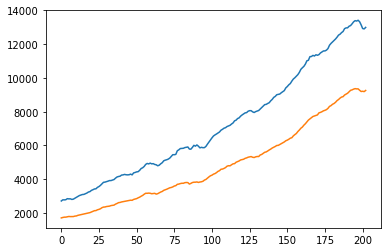

In [7]:
plt.plot(df)

In [9]:
#You would want to see if there’s a correlation between the variables
# import for Granger's Causality Test

#Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
#In simpler terms, the past values of time series (X) do not cause the other series (Y).
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(df, maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.1879  , p=0.6646  , df=1
likelihood ratio test: chi2=0.1878  , p=0.6647  , df=1
parameter F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=47.0132 , p=0.0000  , df=2
likelihood ratio test: chi2=42.2456 , p=0.0000  , df=2
parameter F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2


In [18]:
#Cointegration test helps to establish the presence of a statistically 
#significant connection between two or more time series.
#When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.
#This is the basic premise on which Vector Autoregression(VAR) models is based on.

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
realgdp ::  15.87     > 12.3212   =>   True
realcons ::  1.56      > 4.1296    =>   False


In [10]:
# Split data
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

In [11]:
#Check for stationarity
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train["realgdp"])
adf_test(df_train["realcons"])

Test Statistic            1.915476
p-value                   0.998553
# Lags                    2.000000
# Observations          196.000000
Critical Value (1%)      -3.464161
Critical Value (5%)      -2.876402
Critical Value (10%)     -2.574692
dtype: float64
 Series is Non-Stationary
Test Statistic            0.755577
p-value                   0.990884
# Lags                    3.000000
# Observations          195.000000
Critical Value (1%)      -3.464337
Critical Value (5%)      -2.876479
Critical Value (10%)     -2.574733
dtype: float64
 Series is Non-Stationary


In [12]:
#Make data stationery
#If the data is not stationary you can make it so in several ways, but the simplest one is taking a first difference. 
# 1st difference
df_differenced = df_train.diff().dropna()
# stationarity test again with differenced data
adf_test(df_differenced["realgdp"])

Test Statistic         -6.126511e+00
p-value                 8.603234e-08
# Lags                  1.000000e+00
# Observations          1.960000e+02
Critical Value (1%)    -3.464161e+00
Critical Value (5%)    -2.876402e+00
Critical Value (10%)   -2.574692e+00
dtype: float64
 Series is Stationary


In [13]:
# model fitting
model = VAR(df_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Jun, 2020
Time:                     16:04:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.2225
Nobs:                     195.000    HQIC:                   14.0826
Log likelihood:          -1903.17    FPE:                1.18772e+06
AIC:                      13.9875    Det(Omega_mle):     1.10683e+06
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              10.539111         6.135458            1.718           0.086
L1.realgdp         -0.135636         0.085377           -1.589           0.112
L1.realcons         0.821284         0.139260            5.897    

In [ ]:
#подобрать итеративно лучший лаг

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

In [21]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

realgdp : 1.97
realcons : 1.95


In [22]:
# forecasting
#In order to forecast, the VAR model expects up to the lag order number of observations from the past data.
lag_order = results.k_ar
print(lag_order)
results.forecast(df.values[-lag_order:], 5)

3


array([[10290.5747705 ,  6613.2380308 ],
       [ 8517.53900903,  6003.61472148],
       [ 7019.68760716,  5249.17897406],
       [ 6137.23354248,  4201.22699968],
       [ 5146.61872133,  3726.24493242]])

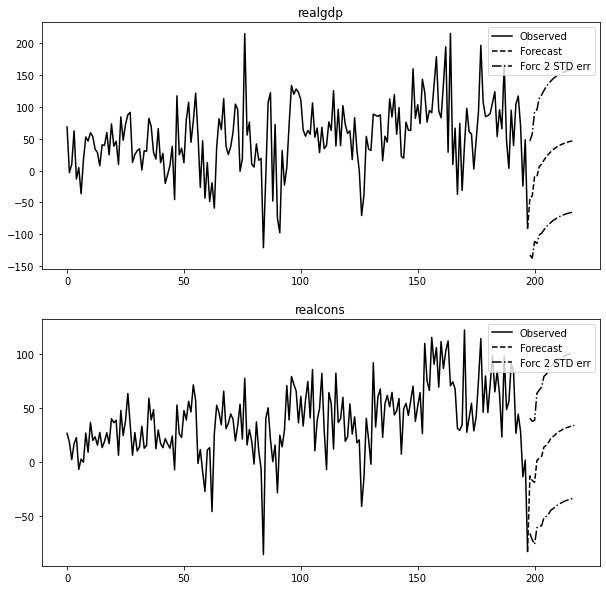

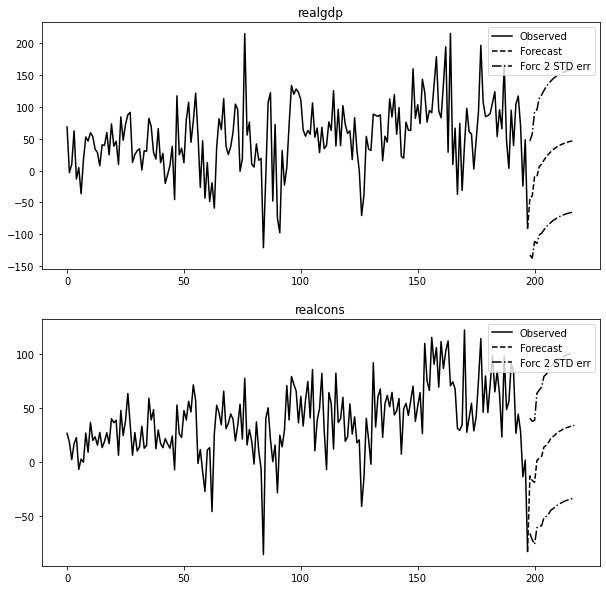

In [15]:
# plotting
results.plot_forecast(20)

In [16]:
# Evaluation
fevd = results.fevd(5)
fevd.summary()

FEVD for realgdp
      realgdp  realcons
0    1.000000  0.000000
1    0.855210  0.144790
2    0.806136  0.193864
3    0.762372  0.237628
4    0.732677  0.267323

FEVD for realcons
      realgdp  realcons
0    0.284790  0.715210
1    0.273130  0.726870
2    0.261571  0.738429
3    0.224091  0.775909
4    0.219314  0.780686




In [17]:
#Inverting
#One final step remains. You didn’t fit the model to original data, 
#because you had to transform (first difference) it to make data stationary 
# forecasting
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['realgdp_forecast', 'realcons_forecast']]

C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,realgdp_forecast,realcons_forecast
199,13190.828174,9171.244529
200,13017.091744,9057.303996
201,12834.042004,8924.194948
202,12641.596233,8792.278617


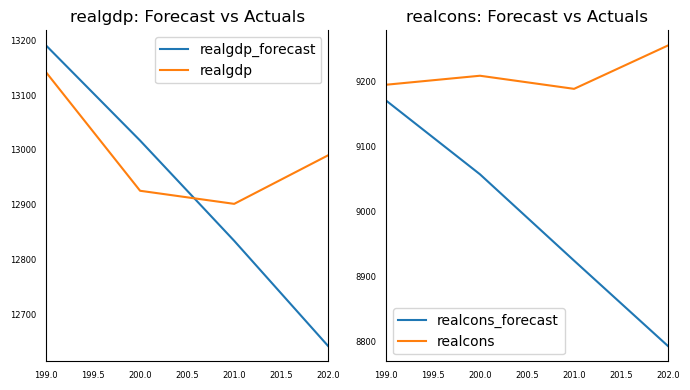

In [27]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=100, figsize=(7,4))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# VARMAX

In [1]:
# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)

C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


[[0.50254604 0.9722521 ]]


C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\vzhyvov\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
